In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import warnings
from math import sin, cos, sqrt, atan2, radians,asin

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
warnings.filterwarnings('ignore')

In [46]:
train=pd.read_csv("train.csv",nrows=3000000)
print("Shape of Training Data",train.shape)
test=pd.read_csv("test.csv")
print("Shape of Testing Data", test.shape)

Shape of Training Data (3000000, 8)
Shape of Testing Data (9914, 7)


### Clean the data 
1. Remove fare amount < 0 
2. Passenger count > 7 remove from train data
3. Use only the fields that are present to create Baseline Model - have only date features. Rest of the features we will add later

In [47]:
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
def clean_data(data):
    boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}
    
    data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
    data['pickup_day']=data['pickup_datetime'].apply(lambda x:x.day)
    data['pickup_hour']=data['pickup_datetime'].apply(lambda x:x.hour)
    data['pickup_day_of_week']=data['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    data['pickup_month']=data['pickup_datetime'].apply(lambda x:x.month)
    data['pickup_year']=data['pickup_datetime'].apply(lambda x:x.year)
    if 'fare_amount' in data.columns:
        data=data[data['fare_amount']>=0]
        data.loc[~((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
        data.loc[((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

    #print("Outlier vs Non Outlier Counts")
    #print(data['is_outlier_loc'].value_counts())

    # Let us drop rows, where location is outlier
        data=data.loc[data['is_outlier_loc']==0]
        data.drop(['is_outlier_loc'],axis=1,inplace=True)
    
    data=data[data['passenger_count']<=8]
    data['pickup_day_of_week']=data['pickup_day_of_week'].apply(lambda x:encodeDays(x))
    return data

In [48]:
train=clean_data(train)
test=clean_data(test)
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)

Shape of Training Data after cleaning  (2935680, 13)
Shape of Testing Data after cleaning (9914, 12)


### Create a function to process data for Modelling
This step includes:
1. Dropping unwanted columns from the data
2. One Hot Encoding of categorical variables
3. Dividing training data into train and validation data sets
    1. features and target varible must be seperated
    2. split ratio must be passed as an argument 

In [49]:
def processDataForModelling(data,target,drop_cols,is_train=True,split=0.25):
    data_1=data.drop(drop_cols,axis=1)
    # One hot Encoding
    data_1=pd.get_dummies(data_1)
    if is_train==True:
        X=data_1.drop([target],axis=1)
        y=data_1[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=123)
        
        print("Shape of Training Features",X_train.shape)
        print("Shape of Validation Features ",X_test.shape)
        
        return X_train, X_test, y_train, y_test
    else:
        print ("Shape of Test Data",data_1.shape)
        return data_1
    

In [50]:
X_train, X_test, y_train, y_test=processDataForModelling(train,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=True,split=0.2)

Shape of Training Features (2348544, 10)
Shape of Validation Features  (587136, 10)


In [51]:
test_data=processDataForModelling(test,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=False)

Shape of Test Data (9914, 10)


### Building a Baseline Model and Identifying a good ML algorithm for this problem
The metric used in this problem is RMSE. 
We will try three models - Linear Regression, Random Forest and XGBoost and see which model performs better.
We will use the best model among the three to further tune and apply feature Engineering

For Baseline, we will predict the average fare amount and check the RMSE on validation data. Any model, should be able to beat this simple benchmark

In [8]:
avg_fare=round(np.mean(y_train),2)
avg_fare

11.31

In [9]:
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Baseline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 9.707556295335856


##### Build a Linear Regression Model 

In [32]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=np.round(lm.predict(X_test),2)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  8.14028848424604


The linear regression model performed better than than the Baseline Mode. Let us create a Random Forest Model and see how it performs. Reason for failure of logistic regression model, is that it tries to fit a linear line between the variables and the targer. But, as we saw in the Exploratory analysis phase this is not true. 

##### Build a Random Forest Model 

In [9]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=883, verbose=0, warm_start=False)

In [10]:
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  3.722760643979709


Random Forest has reduced the RMSE considerably as compared to Linear Regression. Random Forest works on the principle of Bagging
The idea behind this is very intutive- when we want to make a decision about a field we do not know about we take advice from a people and then we decide based on the majority opinion.
This is the idea behind Random Forest - multiple decision trees are created and output from each of the trees are averaged to predict the value.
Random Forest are not susceptible to overfitting and since in Random Forest, each tree is trained independently of the other, it is more robust.

The next type of algorithm we will see is also another Tree based Ensemble algorithm - but it follows concept of Boosting. 




#### Building LightGBM Algorithm

In [11]:
train_data=lgb.Dataset(X_train,label=y_train)


In [12]:
param = {'num_leaves':31, 'num_trees':5000, 'objective':'regression'}
param['metric'] = 'l2_root'

In [13]:
num_round=5000
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=20, early_stopping_rounds=20,stratified=False)

[20]	cv_agg's rmse: 5.06937 + 0.0937088
[40]	cv_agg's rmse: 4.51336 + 0.10132
[60]	cv_agg's rmse: 4.31256 + 0.0979842
[80]	cv_agg's rmse: 4.22526 + 0.0978898
[100]	cv_agg's rmse: 4.16198 + 0.0975422
[120]	cv_agg's rmse: 4.11534 + 0.100577
[140]	cv_agg's rmse: 4.08472 + 0.0993362
[160]	cv_agg's rmse: 4.06033 + 0.100064
[180]	cv_agg's rmse: 4.03975 + 0.101011
[200]	cv_agg's rmse: 4.02197 + 0.100109
[220]	cv_agg's rmse: 4.00684 + 0.102158
[240]	cv_agg's rmse: 3.99238 + 0.103733
[260]	cv_agg's rmse: 3.98044 + 0.102612
[280]	cv_agg's rmse: 3.97015 + 0.100662
[300]	cv_agg's rmse: 3.9603 + 0.100332
[320]	cv_agg's rmse: 3.95286 + 0.099647
[340]	cv_agg's rmse: 3.94603 + 0.100222
[360]	cv_agg's rmse: 3.93663 + 0.0989949
[380]	cv_agg's rmse: 3.93024 + 0.0996305
[400]	cv_agg's rmse: 3.92465 + 0.100501
[420]	cv_agg's rmse: 3.91913 + 0.100063
[440]	cv_agg's rmse: 3.9146 + 0.0998755
[460]	cv_agg's rmse: 3.91079 + 0.100746
[480]	cv_agg's rmse: 3.9063 + 0.100846
[500]	cv_agg's rmse: 3.9024 + 0.100475
[

In [14]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))
#lgb_pred = lgb_bst.predict(X_test)

Best num_boost_round: 2482


In [15]:
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))

In [16]:
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM is ",lgb_rmse)

RMSE for Light GBM is  3.7899881516524565


Random Forest is better than Light GBM. Let us also create a XGBOOST Model and see how it performs.

In [20]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [23]:
xgb_param = {'objective':'reg:linear','eval_metric':'rmse'}
xgb_cv=xgb.cv(xgb_param, dtrain, num_boost_round=5000, nfold=5,early_stopping_rounds=20)

[17:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:52:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:52:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:52:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:52:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:52:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:52:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

In [27]:
nrounds=xgb_cv.shape[0]

In [28]:
xbg_model=xgb.train(params={'objective':'reg:linear','eval_metric':'rmse'}
                    ,dtrain=dtrain,num_boost_round=nrounds)


[19:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[19:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[19:42:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned no

In [30]:
xgb_pred=xbg_model.predict(dtest)
xgb_rmse=np.sqrt(mean_squared_error(xgb_pred, y_test))
print("RMSE for XGBOOST is ",xgb_rmse)

RMSE for XGBOOST is  3.772174090972271


### For each of the model we have built above, let us see what is the train RMSE and test RMSE - This will help us understand variance in the model and get the best model

In [33]:
model_pred=pd.DataFrame()
model_pred['model_name']=['Linear Regression','Random Forest','Light GBM','XGBOOST']
model_pred['test_rmse']=[lm_rmse,rf_rmse,lgb_rmse,xgb_rmse]

In [35]:
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train), y_train))
rf_train_rmse=np.sqrt(mean_squared_error(rf.predict(X_train),y_train))
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),y_train))
xgb_train_rmse=np.sqrt(mean_squared_error(xbg_model.predict(dtrain),y_train))

model_pred['train_rmse']=[lm_train_rmse,rf_train_rmse,lgb_train_rmse,xgb_train_rmse]

In [47]:
model_pred['variance']=model_pred['train_rmse'] - model_pred['test_rmse']
model_pred

model_name  test_rmse  train_rmse  variance
0  Linear Regression   8.140288    8.209541  0.069252
1      Random Forest   3.722761    1.412086 -2.310674
2          Light GBM   3.789988    3.301217 -0.488771
3            XGBOOST   3.772174    3.209402 -0.562772

We can see that there is a very high difference in the train and test RMSE for Random Forest, though overall the test-rmse of Random Forest is the best. Very high variance is a sign of overfitting. 
XGBOOST has done slighlty better than Light GBM in terms of training and test rmse - but variance is higher in XGBOOST
In further work, we will consider LightGBM as the model and add features and tune this model. 

#### Feature Engineering

In [52]:
nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [53]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490

    }
}


def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [54]:

X_train['is_pickup_la_guardia']=X_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
X_train['is_dropoff_la_guardia']=X_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
X_train['is_pickup_EWR']=X_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
X_train['is_dropoff_EWR']=X_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
X_train['is_pickup_JFK']=X_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
X_train['is_dropoff_JFK']=X_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)




X_test['is_pickup_la_guardia']=X_test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
X_test['is_dropoff_la_guardia']=X_test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
X_test['is_pickup_EWR']=X_test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
X_test['is_dropoff_EWR']=X_test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
X_test['is_pickup_JFK']=X_test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
X_test['is_dropoff_JFK']=X_test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)


test['is_pickup_la_guardia']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
test['is_dropoff_la_guardia']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
test['is_pickup_EWR']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
test['is_dropoff_EWR']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
test['is_pickup_JFK']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
test['is_dropoff_JFK']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)



In [55]:
def getBorough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'
X_train['pickup_borough']=X_train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_train['dropoff_borough']=X_train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
X_test['pickup_borough']=X_test.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_test['dropoff_borough']=X_test.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

test['pickup_borough']=test.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['dropoff_borough']=test.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test)
test=pd.get_dummies(test)

In [56]:
lower_manhattan_boundary={'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat>=lower_manhattan_boundary['min_lat'] and lat<=lower_manhattan_boundary['max_lat'] and lng>=lower_manhattan_boundary['min_lng'] and lng<=lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0

In [57]:
X_train['is_pickup_lower_manhattan']=X_train.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_train['is_dropoff_lower_manhattan']=X_train.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [58]:
X_test['is_pickup_lower_manhattan']=X_test.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_test['is_dropoff_lower_manhattan']=X_test.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

test['is_pickup_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['is_dropoff_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)


In [59]:
def distance(lat1,lon1,lat2,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
#X_train['trip_distance']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
#X_test['trip_distance']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

#test['trip_distance']=test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

lgr=(-73.8733, 40.7746)
jfk=(-73.7900, 40.6437)
ewr=(-74.1843, 40.6924)

test['pickup_distance_jfk']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
test['dropoff_distance_jfk']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
test['pickup_distance_ewr']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
test['dropoff_distance_ewr']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
test['pickup_distance_laguardia']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
test['dropoff_distance_laguardia']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)

X_train['pickup_distance_jfk']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
X_train['dropoff_distance_jfk']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
X_train['pickup_distance_ewr']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
X_train['dropoff_distance_ewr']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
X_train['pickup_distance_laguardia']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
X_train['dropoff_distance_laguardia']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)

X_test['pickup_distance_jfk']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
X_test['dropoff_distance_jfk']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
X_test['pickup_distance_ewr']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
X_test['dropoff_distance_ewr']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
X_test['pickup_distance_laguardia']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
X_test['dropoff_distance_laguardia']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)

In [60]:
manhattan=(-73.9664, 40.7909)
queens=(-73.8317, 40.7038)
brooklyn=(-73.9489, 40.6551)
bronx=(-73.8568, 40.8572)
staten_island=(-74.1540, 40.5725)




test['pickup_distance_manhattan']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],manhattan[1],manhattan[0]),axis=1)
test['pickup_distance_queens']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],queens[1],queens[0]),axis=1)
test['pickup_distance_brooklyn']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],brooklyn[1],brooklyn[0]),axis=1)
test['pickup_distance_bronx']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],bronx[1],bronx[0]),axis=1)
test['pickup_distance_statenisland']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],staten_island[1],staten_island[0]),axis=1)





test['dropoff_distance_manhattan']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],manhattan[1],manhattan[0]),axis=1)
test['dropoff_distance_queens']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],queens[1],queens[0]),axis=1)
test['dropoff_distance_brooklyn']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],brooklyn[1],brooklyn[0]),axis=1)
test['dropoff_distance_bronx']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],bronx[1],bronx[0]),axis=1)
test['dropoff_distance_statenisland']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],staten_island[1],staten_island[0]),axis=1)


X_train['pickup_distance_manhattan']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],manhattan[1],manhattan[0]),axis=1)
X_train['pickup_distance_queens']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],queens[1],queens[0]),axis=1)
X_train['pickup_distance_brooklyn']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],brooklyn[1],brooklyn[0]),axis=1)
X_train['pickup_distance_bronx']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],bronx[1],bronx[0]),axis=1)
X_train['pickup_distance_statenisland']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],staten_island[1],staten_island[0]),axis=1)

X_train['dropoff_distance_manhattan']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],manhattan[1],manhattan[0]),axis=1)
X_train['dropoff_distance_queens']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],queens[1],queens[0]),axis=1)
X_train['dropoff_distance_brooklyn']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],brooklyn[1],brooklyn[0]),axis=1)
X_train['dropoff_distance_bronx']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],bronx[1],bronx[0]),axis=1)
X_train['dropoff_distance_statenisland']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],staten_island[1],staten_island[0]),axis=1)




X_test['pickup_distance_manhattan']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],manhattan[1],manhattan[0]),axis=1)
X_test['pickup_distance_queens']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],queens[1],queens[0]),axis=1)
X_test['pickup_distance_brooklyn']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],brooklyn[1],brooklyn[0]),axis=1)
X_test['pickup_distance_bronx']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],bronx[1],bronx[0]),axis=1)
X_test['pickup_distance_statenisland']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],staten_island[1],staten_island[0]),axis=1)

X_test['dropoff_distance_manhattan']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],manhattan[1],manhattan[0]),axis=1)
X_test['dropoff_distance_queens']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],queens[1],queens[0]),axis=1)
X_test['dropoff_distance_brooklyn']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],brooklyn[1],brooklyn[0]),axis=1)
X_test['dropoff_distance_bronx']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],bronx[1],bronx[0]),axis=1)
X_test['dropoff_distance_statenisland']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],staten_island[1],staten_island[0]),axis=1)




In [61]:
X_train.to_csv("X_train_cleaned.csv",index=False)
X_test.to_csv("X_test_cleaned.csv",index=False)
test.to_csv("test_cleaned.csv",index=False)

In [26]:
train_data=lgb.Dataset(X_train,label=y_train)
param = {'num_leaves':31, 'num_trees':5000, 'objective':'regression'}
param['metric'] = 'l2_root'

In [27]:
num_round=5000
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=5,verbose_eval=20, early_stopping_rounds=20,stratified=False)

[20]	cv_agg's rmse: 4.94109 + 0.0573428
[40]	cv_agg's rmse: 4.34261 + 0.0457261
[60]	cv_agg's rmse: 4.15224 + 0.0491419
[80]	cv_agg's rmse: 4.05312 + 0.0451869
[100]	cv_agg's rmse: 3.9812 + 0.0436392
[120]	cv_agg's rmse: 3.93479 + 0.0450728
[140]	cv_agg's rmse: 3.90136 + 0.0437222
[160]	cv_agg's rmse: 3.87726 + 0.0454694
[180]	cv_agg's rmse: 3.85926 + 0.0447193
[200]	cv_agg's rmse: 3.84319 + 0.047186
[220]	cv_agg's rmse: 3.83059 + 0.0455051
[240]	cv_agg's rmse: 3.81928 + 0.0427985
[260]	cv_agg's rmse: 3.80999 + 0.0428492
[280]	cv_agg's rmse: 3.80055 + 0.046024
[300]	cv_agg's rmse: 3.79352 + 0.0448405
[320]	cv_agg's rmse: 3.78686 + 0.0439405
[340]	cv_agg's rmse: 3.77965 + 0.0442354
[360]	cv_agg's rmse: 3.77355 + 0.0450437
[380]	cv_agg's rmse: 3.7686 + 0.0453594
[400]	cv_agg's rmse: 3.76363 + 0.0461066
[420]	cv_agg's rmse: 3.75992 + 0.0468067
[440]	cv_agg's rmse: 3.75453 + 0.0468473
[460]	cv_agg's rmse: 3.75015 + 0.0470595
[480]	cv_agg's rmse: 3.74567 + 0.0474351
[500]	cv_agg's rmse: 3.7

In [28]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))

Best num_boost_round: 2040


In [29]:
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))

In [30]:
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM with Feature Engineering is ",lgb_rmse)

RMSE for Light GBM with Feature Engineering is  3.6415988311191283


In [31]:
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),y_train))
print("Train RMSE for Light GBM with Feature Engineering is", lgb_train_rmse)

Train RMSE for Light GBM with Feature Engineering is 3.1609195102603014


In [32]:
variance=lgb_train_rmse - lgb_rmse
print("Variance of Light GBM with Feature Engineering is ", variance)

Variance of Light GBM with Feature Engineering is  -0.4806793208588269


With Feature Engineering, the RMSE has decreased from 3.78 to 3.64. The variance of the model has also come down from 0.5 to 0.48. Let us tune Light GBM Model

### Tuning Light GBM

1. max_depth - this parameter is used to handle overfitting. If model overfits - reduce this value
2. min_data_in_leaf - this is the minimum number of records in each leaf - increase this value to reduce overfitting
3. learning rate - impact of each tree on the final outcome - smaller learning rate with more iterations increases the accuracy
4. num_leaves - this is the main factor that effects the model. 
5. Baggin_fraction - specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting
6.feature_fraction - specifies fraction of features to be used in each iteration


In [39]:

param={'metric': 'l2_root',
 
 'objective': 'regression',
 'verbose': 1,
 #'num_trees':1000
      } #Light GBM with these params had an test rmse on 3.65

In [40]:
gridparams={
    'learning_rate':[0.1,0.75,0.005,0.025],
    #'num_iterations':[100,250,500],
    'num_leaves':[31,60],
    'bagging_freq':[10,20],
    'bagging_fraction':[0.85,1,0.9,0.95],
    'boosting_type':['gbdt']
    #'subsample':[1,0.8,0.75],
    #'colsample_bytree':[0.8,0.7,1],
    'max_depth':[-1,6,5]
}

In [41]:
mdl = lgb.LGBMRegressor(
          objective = 'regression',
          n_jobs = -1, # Updated from 'nthread'
          verbose=1,
          metric='l2_root')

In [42]:
grid = GridSearchCV(mdl, gridparams,
                    verbose=1,
                    cv=3,
                    n_jobs=-1)

In [ ]:
grid.fit(X_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [ ]:
grid.best_params_

In [ ]:
bst_params={'metric': 'l2_root',
 'num_leaves': grid.best_params_['num_leaves'],
 
  'learning_rate':grid.best_params_['learning_rate'],
  'n_estimators':grid.best_params_['n_estimators'],
            
 'objective': 'regression',
 'verbose': 1,
 }

In [132]:
num_round=5000
cv_results = lgb.cv(bst_params, train_data, num_boost_round=num_round, nfold=5,verbose_eval=20, early_stopping_rounds=20,stratified=False)

[20]	cv_agg's rmse: 4.62811 + 0.0419378
[40]	cv_agg's rmse: 4.14044 + 0.0468021
[60]	cv_agg's rmse: 3.99519 + 0.0486395
[80]	cv_agg's rmse: 3.91427 + 0.0486414
[100]	cv_agg's rmse: 3.86582 + 0.0488141
[120]	cv_agg's rmse: 3.8304 + 0.0492926
[140]	cv_agg's rmse: 3.8076 + 0.0492342
[160]	cv_agg's rmse: 3.79095 + 0.0495056
[180]	cv_agg's rmse: 3.77776 + 0.0502699
[200]	cv_agg's rmse: 3.76638 + 0.0512947
[220]	cv_agg's rmse: 3.75739 + 0.0520557
[240]	cv_agg's rmse: 3.75112 + 0.0528947


In [133]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))

Best num_boost_round: 250


In [134]:
lgb_bst=lgb.train(bst_params,train_data)

In [135]:
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM with Feature Engineering is ",lgb_rmse)
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),y_train))
print("Train RMSE for Light GBM with Feature Engineering is", lgb_train_rmse)
variance=lgb_train_rmse - lgb_rmse
print("Variance of Light GBM with Feature Engineering is ", variance)

RMSE for Light GBM with Feature Engineering is  3.715336443817657
Train RMSE for Light GBM with Feature Engineering is 3.5243966287184767
Variance of Light GBM with Feature Engineering is  -0.19093981509918034


https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html

### Let us XGB Regressor using Hyperopt and get the best params

In [78]:
X_train=pd.read_csv("X_train_cleaned.csv")
X_test=pd.read_csv("X_test_cleaned.csv")
#y_train=pd.read_csv("Y_Train.csv")
#y_test=pd.read_csv("Y_test.csv")

In [20]:
def objective(space):

    clf = lgb.LGBMRegressor(
          objective = 'regression',
          n_jobs = -1, # Updated from 'nthread'
          verbose=1,
          boosting_type='gbdt',
        num_leaves=60,
        bagging_freq=20,
       subsample_freq=100,
    max_depth=int(space['max_depth']),
    subsample=space['subsample'],
        n_estimators=5000,
    colsample_bytree=space['colsample'])
          #metric='l2_root')

    eval_set=[( X_train, y_train), ( X_test,y_test)]

    clf.fit(X_train, np.array(y_train),
            eval_set=eval_set,eval_metric='rmse',
            early_stopping_rounds=20)

    pred = clf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print("SCORE:", rmse)

    return{'loss':rmse, 'status': STATUS_OK }



In [21]:
space ={
        'max_depth': hp.quniform("x_max_depth", 5, 30, 3),
        #'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'colsample':hp.uniform ('x_colsample', 0.3, 1)
    }

In [22]:
from hyperopt.mongoexp import MongoTrials
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

[1]	valid_0's rmse: 8.98197	valid_1's rmse: 8.94112
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's rmse: 8.39324	valid_1's rmse: 8.35439
[3]	valid_0's rmse: 7.88079	valid_1's rmse: 7.84296
[4]	valid_0's rmse: 7.43755	valid_1's rmse: 7.4004
[5]	valid_0's rmse: 7.05396	valid_1's rmse: 7.01826
[6]	valid_0's rmse: 6.71198	valid_1's rmse: 6.67742
[7]	valid_0's rmse: 6.41946	valid_1's rmse: 6.38683
[8]	valid_0's rmse: 6.16392	valid_1's rmse: 6.13193
[9]	valid_0's rmse: 5.94442	valid_1's rmse: 5.91339
[10]	valid_0's rmse: 5.75591	valid_1's rmse: 5.72518
[11]	valid_0's rmse: 5.60394	valid_1's rmse: 5.57498
[12]	valid_0's rmse: 5.45389	valid_1's rmse: 5.42615
[13]	valid_0's rmse: 5.33114	valid_1's rmse: 5.30507
[14]	valid_0's rmse: 5.20365	valid_1's rmse: 5.1788
[15]	valid_0's rmse: 5.10955	valid_1's rmse: 5.08594
[16]	valid_0's rmse: 5.02032	valid_1's rmse: 4.99752
[17]	valid_0's rmse: 4.91677	valid_1's rmse: 4.89428
[18]	valid_0's rmse: 4.85765	valid_1's rmse: 4.8

In [23]:
print(best)

{'x_max_depth': 24.0, 'x_subsample': 0.9988461076307639, 'x_colsample': 0.38429620148564814}


In [79]:
clf = lgb.LGBMRegressor(
          objective = 'regression',
          n_jobs = -1, # Updated from 'nthread'
          verbose=1,
          boosting_type='gbdt',
        num_leaves=60,
        bagging_freq=20,
       subsample_freq=100,
    max_depth=int(best['x_max_depth']),
    subsample=best['x_subsample'],
        n_estimators=5000,
    colsample_bytree=best['x_colsample'])
          #metric='l2_root')

In [80]:
eval_set=[( X_train, y_train), ( X_test,y_test)]
clf.fit(X_train, np.array(y_train),eval_set=eval_set,eval_metric='rmse',early_stopping_rounds=20)

[1]	valid_0's rmse: 8.9798	valid_1's rmse: 8.93914
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's rmse: 8.39323	valid_1's rmse: 8.35406
[3]	valid_0's rmse: 7.85848	valid_1's rmse: 7.82037
[4]	valid_0's rmse: 7.39007	valid_1's rmse: 7.35339
[5]	valid_0's rmse: 6.99438	valid_1's rmse: 6.95927
[6]	valid_0's rmse: 6.65308	valid_1's rmse: 6.61947
[7]	valid_0's rmse: 6.37012	valid_1's rmse: 6.33836
[8]	valid_0's rmse: 6.11505	valid_1's rmse: 6.08418
[9]	valid_0's rmse: 5.87288	valid_1's rmse: 5.84327
[10]	valid_0's rmse: 5.66594	valid_1's rmse: 5.63734
[11]	valid_0's rmse: 5.48534	valid_1's rmse: 5.45723
[12]	valid_0's rmse: 5.33163	valid_1's rmse: 5.30408
[13]	valid_0's rmse: 5.20221	valid_1's rmse: 5.17543
[14]	valid_0's rmse: 5.09328	valid_1's rmse: 5.06747
[15]	valid_0's rmse: 4.9763	valid_1's rmse: 4.95102
[16]	valid_0's rmse: 4.87357	valid_1's rmse: 4.84898
[17]	valid_0's rmse: 4.77735	valid_1's rmse: 4.75322
[18]	valid_0's rmse: 4.71395	valid_1's rmse: 4.6

LGBMRegressor(bagging_freq=20, boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.38429620148564814, learning_rate=0.1,
       max_depth=24, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=60,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.9988461076307639,
       subsample_for_bin=200000, subsample_freq=100, verbose=1)

In [81]:
valid_pred = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, valid_pred))
print("Validation RMSE after tuning ",rmse)
pred = clf.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, pred))
print("Train RMSE after tuning",train_rmse)
print("Variance of model ", abs(train_rmse - rmse))

Validation RMSE after tuning  3.6336313014816652
Train RMSE after tuning 3.1843509138801633
Variance of model  0.4492803876015019


Tuning the model has reudced the rmse from 3.646 to 3.630 and variance from 0.48 to 0.43. 

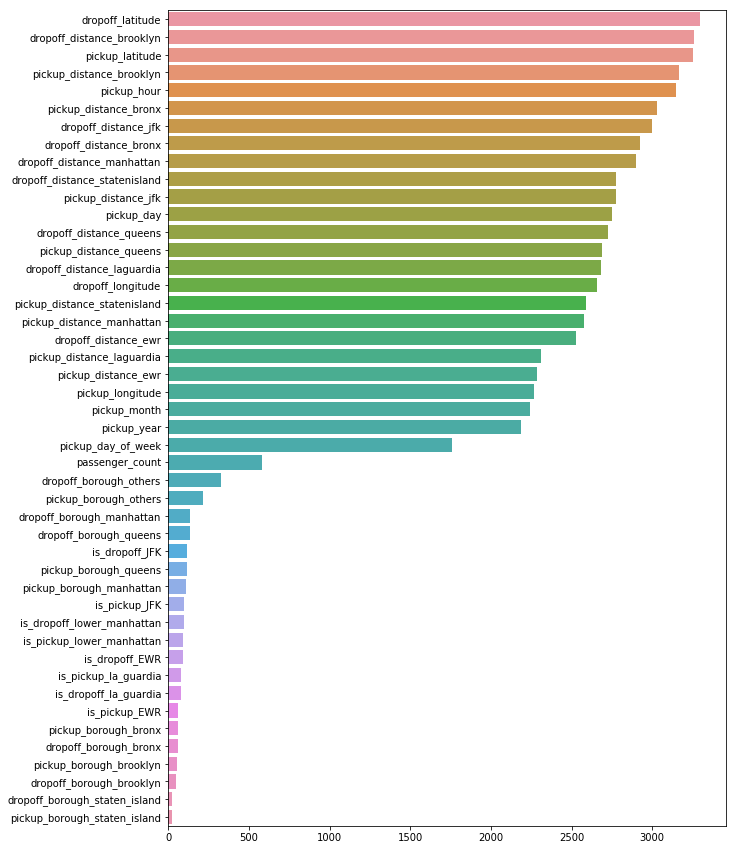

In [82]:
lgbm_feature_importance=sorted(zip(map(lambda x: round(x, 4),clf.feature_importances_), X_train.columns),reverse=True)
plt.figure(figsize=(10,15))
sns.barplot([imp for imp,feature in lgbm_feature_importance],[feature for imp,feature in lgbm_feature_importance])

#Training score

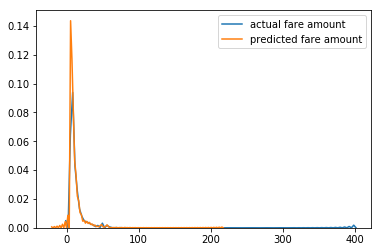

In [85]:
sns.kdeplot(np.log(y_test),label='actual fare amount')
sns.kdeplot(np.log(valid_pred,label='predicted fare amount')